## Лабораторная работа №5

#### Импорт библиотек

In [71]:
import warnings
from itertools import combinations
from typing import Any
from typing import Tuple, List

import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt
from sklearn.base import is_classifier, is_regressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, AdaBoostRegressor,
                              BaggingClassifier, BaggingRegressor,
                              StackingClassifier, StackingRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import KNNImputer
from sklearn.linear_model import (BayesianRidge, ElasticNet, Lasso,
                                  LogisticRegression, Ridge)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings("ignore", category=ConvergenceWarning)


## Классификация

In [72]:
data = pd.read_csv("train.csv").drop(columns=["PassengerId", "Cabin", "Name", "Ticket"])

category_cols = ("Survived", "Pclass", "Sex", "Embarked")
numeric_cols = ("Age", "SibSp", "Parch", "Fare")
target = "Survived"

# Impute missing values in the "Age" column using KNNImputer
knn_imputer = KNNImputer()
data[["Age"]] = knn_imputer.fit_transform(data[["Age"]])

# Encode categorical variables using LabelEncoder
encoder = LabelEncoder()
for col in category_cols:
    data[col] = encoder.fit_transform(data[col])

# Scale numeric variables using MinMaxScaler
scaler = MinMaxScaler()
for col in numeric_cols:
    data[col] = pd.DataFrame(scaler.fit_transform(data[[col]]))

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  534 non-null    int64  
 1   Pclass    534 non-null    int64  
 2   Sex       534 non-null    int32  
 3   Age       534 non-null    float64
 4   SibSp     534 non-null    float64
 5   Parch     534 non-null    float64
 6   Fare      534 non-null    float64
 7   Embarked  534 non-null    int32  
dtypes: float64(4), int32(2), int64(2)
memory usage: 29.3 KB


## Семплирование, разбиение данных

In [73]:
# Разделение данных на признаки и целевую переменную
x = data.drop(columns=[target])
y = data[target]

# Балансировка набора данных с помощью RandomOverSampler
x, y = RandomOverSampler().fit_resample(x, y)

# Разделение данных на обучающий и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

## Функции

In [102]:
def create_barchart(axis: plt.Axes,
                    x: Tuple[Any],
                    y: List[List[float]],
                    title: str,
                    colors: List[str],
                    labels: List[str]) -> None:
    # Create a bar chart
    bar_width = 0.8 / len(y)
    x_pos = np.arange(len(x))
    for i in range(len(y)):
        axis.bar(x_pos + i * bar_width, y[i], bar_width, color=colors[i], label=labels[i])

    # Set the x-ticks and x-tick labels
    axis.set_xticks(x_pos + bar_width / 2)
    axis.set_xticklabels(x)

    # Set the title and add a legend
    axis.set_title(title)
    axis.legend()


def plot_metric(ensemble, base_estimators, n_est_range, x_train, y_train, x_test, y_test, learning_rate=None):
    if not isinstance(ensemble, type):
        ensemble = type(ensemble)
    if is_classifier(ensemble()):
        metric = 'roc_auc'
    else:
        metric = 'r2'
    if learning_rate is not None:
        fig, axs = plt.subplots(2, len(base_estimators), figsize=(15, 10))
    else:
        fig, axs = plt.subplots(1, len(base_estimators), figsize=(15, 5))
    fig.suptitle(str(ensemble).split(".")[-1][:-2])
    best_model = None
    best_hyperparam = None
    best_score = float('-inf')

    total_models = len(base_estimators) * len(n_est_range)

    model_count = 0
    for i, (est_name, estimator) in enumerate(base_estimators.items()):
        if learning_rate is not None:
            ax_row = axs[:, i]
        else:
            ax_row = [axs[i]]
        for j, ax in enumerate(ax_row):
            if j == 0:
                ax.set_title(est_name)
            ax.set_xlabel("n_estimators" if not learning_rate else "learning_rate")
            ax.set_ylabel(metric.upper())
            score = dict.fromkeys(("train", "test", "cv"), tuple())
            param_range = n_est_range if not learning_rate else learning_rate
            for param in param_range:
                params = {"n_estimators": param} if not learning_rate else {"learning_rate": param}
                model = ensemble(estimator(), **params)
                model.fit(x_train, y_train)
                if metric == 'roc_auc':
                    y_pred_train = model.predict_proba(x_train)[:, 1]
                    y_pred_test = model.predict_proba(x_test)[:, 1]
                    train_score = roc_auc_score(y_train, y_pred_train)
                    test_score = roc_auc_score(y_test, y_pred_test)
                    cv_score = cross_val_score(model, x_train, y_train, cv=5).mean()
                elif metric == 'r2':
                    y_pred_train = model.predict(x_train)
                    y_pred_test = model.predict(x_test)
                    train_score = r2_score(y_train, y_pred_train)
                    test_score = r2_score(y_test, y_pred_test)
                    cv_score = cross_val_score(model, x_train, y_train, cv=5).mean()
                score["train"] += (train_score,)
                score["test"] += (test_score,)
                score["cv"] += (cv_score,)
                if test_score > best_score:
                    best_model = est_name
                    best_hyperparam = param
                    best_score = test_score
                model_count += 1
                print(f'Progress: {model_count}/{total_models} models evaluated')
            for label, value in score.items():
                ax.plot(param_range, value, label=label)
            ax.legend(loc="best")
    print(f'Best model: {best_model}')
    print(f'Best hyperparameter: {best_hyperparam}')
    print(f'Best score: {best_score}')

    return best_score


def metric_comb_comp(ensemble, comb: tuple[list[str, Any]], interval: tuple[int, int], metric: str, num: int, x_train,
                     y_train, x_test, y_test):
    """ Построить графики зависимости метрики от комбинаций базовых алгоритмов.
    Аргументы:
    ensemble - класс ансамбля
    comb: tuple[list[str, Any]] - комбинации базовых алгоритмов
    interval: tuple[int] - интервал количества входящих алгоритмов в комбинацию, которые будут отображены
    metric: str - название используемой метрики
    num: int - ограничение количества первых отображенных комбинаций
    x_train - обучающие данные
    y_train - метки обучающих данных
    x_test - тестовые данные
    y_test - метки тестовых данных
    """
    str_comb = []
    train_scores = []
    test_scores = []
    cv_scores = []

    best_combination = None
    best_score = float('-inf')

    abbreviations = {
        'DecisionTreeClassifier': 'DTC',
        'DecisionTreeRegressor': 'DTR',
        'LogisticRegression': 'LR',
        'GaussianNB': 'GNB',
        'KNeighborsClassifier': 'KNC',
        'SVC': 'SVC',
        'LinearDiscriminantAnalysis': 'LDA',
        'QuadraticDiscriminantAnalysis': 'QDA',
        'Lasso': 'Lasso',
        'Ridge': 'Ridge',
        'ElasticNet': 'ElasticNet',
        'BayesianRidge': 'BayesianRidge',
        'KNeighborsRegressor': 'KNR'
    }

    # Перебор комбинаций базовых алгоритмов
    for combination in comb:
        if len(str_comb) == num:
            break

        # Проверка соответствия количества алгоритмов в комбинации заданному интервалу
        if interval[0] <= len(combination) <= interval[1]:
            # Сохранение названий алгоритмов в комбинации
            str_comb.append(",\n".join([abbreviations[x[1].__class__.__name__] for x in combination]))

            # Обучение модели и вычисление счета на тестовых данных
            model = ensemble(combination).fit(x_train, y_train)
            if is_classifier(model):
                train_score = roc_auc_score(y_train, model.predict(x_train))
                test_score = roc_auc_score(y_test, model.predict(x_test))
                cv_score = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc').mean()
            elif is_regressor(model):
                train_score = r2_score(y_train, model.predict(x_train))
                test_score = r2_score(y_test, model.predict(x_test))
                cv_score = cross_val_score(model, x_train, y_train, cv=5, scoring='r2').mean()

            train_scores.append(train_score)
            test_scores.append(test_score)
            cv_scores.append(cv_score)

            if test_score > best_score:
                best_combination = combination
                best_score = test_score

    # Построение графика зависимости метрики от комбинаций базовых алгоритмов
    plt.gcf().set_figwidth(18)
    colors = ['blue', 'orange', 'green']
    labels = ['Train', 'Test', 'CV']

    create_barchart(plt.subplot2grid((1, 2), (0, 0), colspan=2), str_comb,
                    [train_scores, test_scores, cv_scores],
                    "ROC-AUC" if metric == "roc_auc" else "R^2", colors,
                    labels)

    print(f'Best score: {best_score}')

    return best_score

def plot_scores(clfs_names, scores, title, ylabel):
    plt.bar(clfs_names, scores)
    plt.xticks(rotation=45)
    plt.gca().set_title(title)
    plt.gca().set_xlabel('Модели')
    plt.gca().set_ylabel(ylabel)

    for i, score in enumerate(scores):
        plt.gca().text(i, score+0.001, f'{score:.3f}', horizontalalignment='center')

    plt.gca().set_ylim([min(scores) - 0.01, max(scores) + 0.01])
    plt.show()

## Бэггинг

### Построим графики зависимости

### Методы Бэггинга работают параллельно, обучая несколько независимых моделей на различных подмножествах обучающих данных и затем объединяя их прогнозы. Примерами таких методов являются BaggingClassifier и RandomForestClassifier в библиотеке scikit-learn.

In [75]:
base_ests = {
    'DecisionTree': DecisionTreeClassifier,
    'LogisticRegression': LogisticRegression,
    'GaussianNB': GaussianNB
}

Progress: 1/120 models evaluated
Progress: 2/120 models evaluated
Progress: 3/120 models evaluated
Progress: 4/120 models evaluated
Progress: 5/120 models evaluated
Progress: 6/120 models evaluated
Progress: 7/120 models evaluated
Progress: 8/120 models evaluated
Progress: 9/120 models evaluated
Progress: 10/120 models evaluated
Progress: 11/120 models evaluated
Progress: 12/120 models evaluated
Progress: 13/120 models evaluated
Progress: 14/120 models evaluated
Progress: 15/120 models evaluated
Progress: 16/120 models evaluated
Progress: 17/120 models evaluated
Progress: 18/120 models evaluated
Progress: 19/120 models evaluated
Progress: 20/120 models evaluated
Progress: 21/120 models evaluated
Progress: 22/120 models evaluated
Progress: 23/120 models evaluated
Progress: 24/120 models evaluated
Progress: 25/120 models evaluated
Progress: 26/120 models evaluated
Progress: 27/120 models evaluated
Progress: 28/120 models evaluated
Progress: 29/120 models evaluated
Progress: 30/120 models

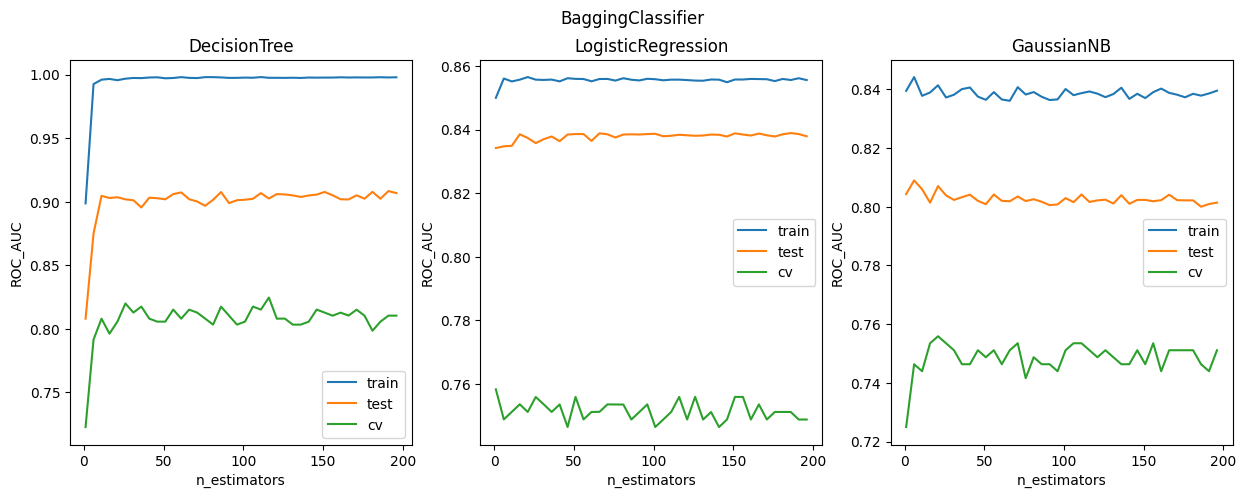

In [76]:
bag_clas_res = plot_metric(BaggingClassifier, base_ests, range(1, 200, 5), x_train,
            y_train,
            x_test, y_test)

## Бустинг

### Бустинг работает последовательно, обучая несколько моделей последовательно, где каждая следующая модель пытается исправить ошибки предыдущей. Примерами таких методов являются AdaBoostClassifier и GradientBoostingClassifier в библиотеке scikit-learn.

Progress: 1/120 models evaluated
Progress: 2/120 models evaluated
Progress: 3/120 models evaluated
Progress: 4/120 models evaluated
Progress: 5/120 models evaluated
Progress: 6/120 models evaluated
Progress: 7/120 models evaluated
Progress: 8/120 models evaluated
Progress: 9/120 models evaluated
Progress: 10/120 models evaluated
Progress: 11/120 models evaluated
Progress: 12/120 models evaluated
Best model: DecisionTree
Best hyperparameter: 0.01
Best score: 0.8934502201282151


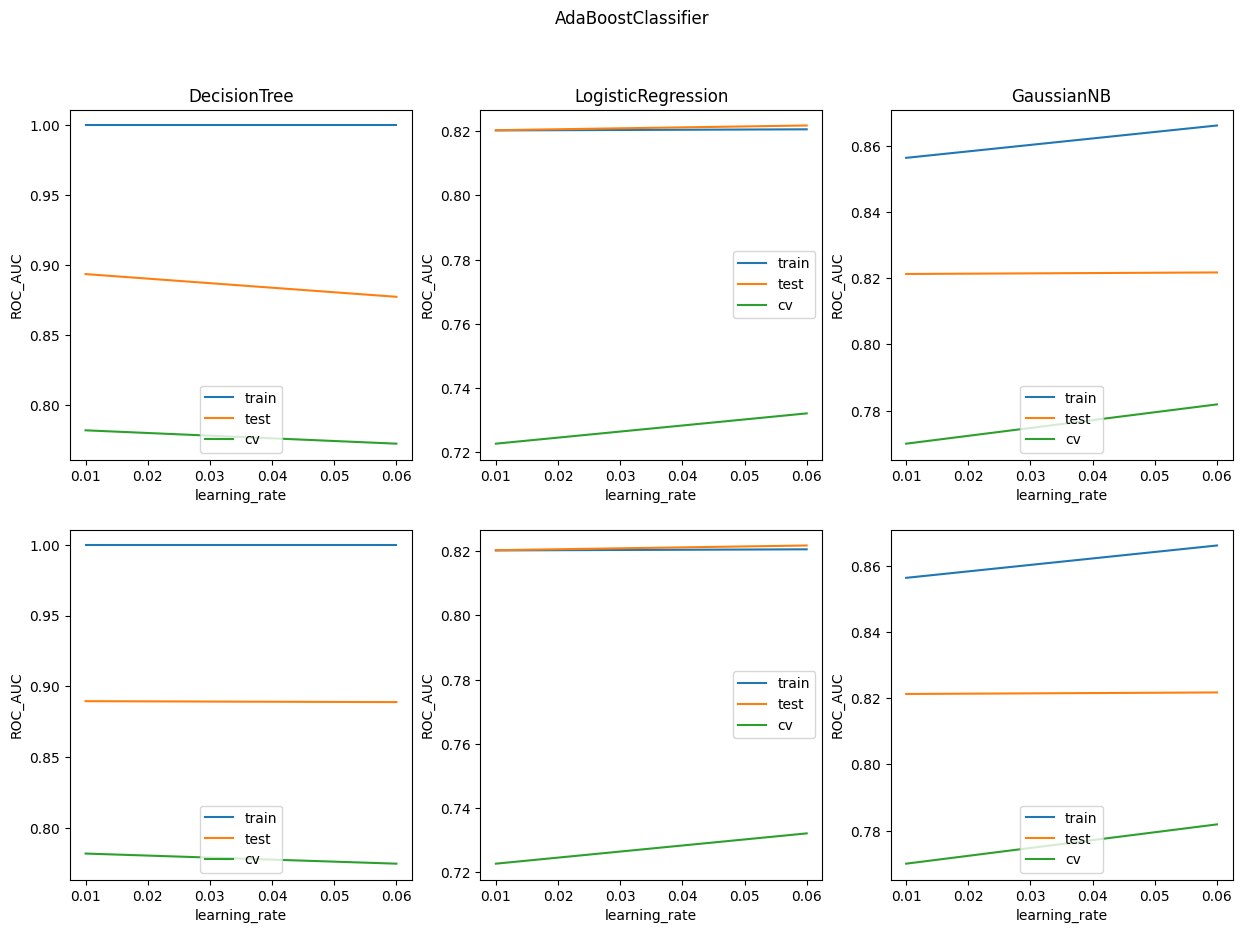

In [77]:
bst_clas_res = plot_metric(AdaBoostClassifier, base_ests, range(1, 200, 5), x_train, y_train, x_test, y_test,
            learning_rate=tuple(x / 100 for x in range(1, 10, 5)))

## Стэкинг

## Построим частичный график зависимости

Best score: 0.8417007801034989


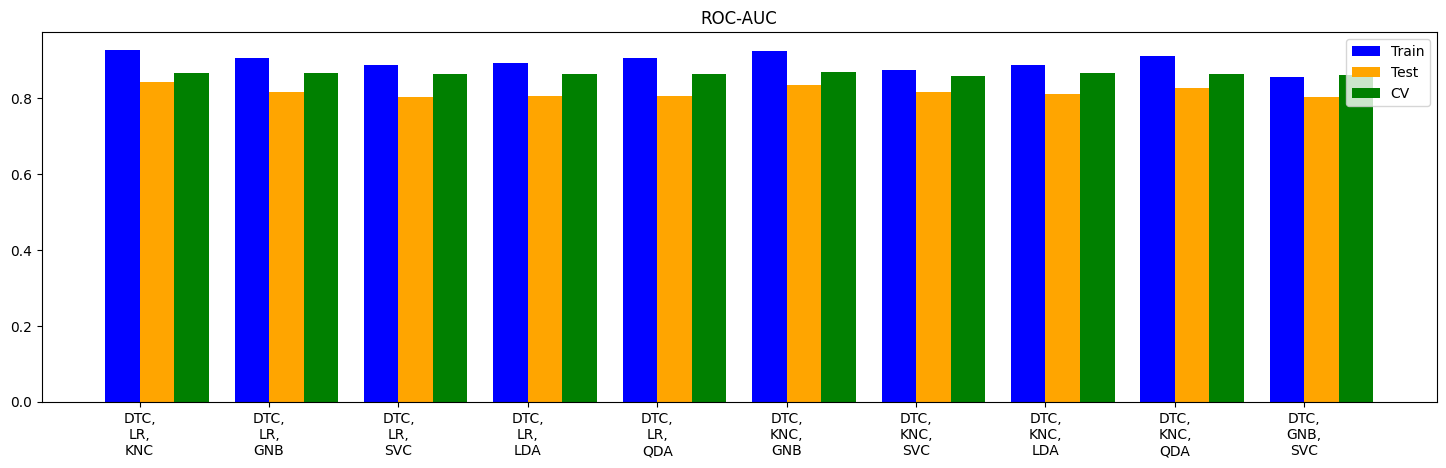

In [78]:
# Создание кортежа с именами и экземплярами различных классификаторов
estimators = (
    ("dtc", DecisionTreeClassifier()),
    ("lr", LogisticRegression()),
    ("knc", KNeighborsClassifier()),
    ("gnb", GaussianNB()),
    ("svc", SVC()),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis())
)

comb = tuple()
for value in range(1, len(estimators) + 1):
    for combination in combinations(estimators, value):
        comb += (list(combination),)

stack_clas_res = metric_comb_comp(StackingClassifier, comb, (3, 3), "roc_auc", 10, x_train, y_train, x_test, y_test)

# Регрессия
## Предобработка данных

In [79]:
data = pd.read_csv("train3.csv").drop(columns=["id"])

numeric = category = tuple()
target = "Цена"

for col in data.drop(columns=[target]).columns:
    if data[col].unique().size <= 3:
        category += (col,)
    else:
        numeric += (col,)

scaler = MinMaxScaler()
for col in numeric:
    data[col] = pd.DataFrame(scaler.fit_transform(data[[col]]))

data.info()

x = data.drop(columns=[target])
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    float64
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    float64
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  

In [80]:
data = pd.read_csv("train3.csv").drop(columns=["id"])

# Определение числовых и категориальных столбцов
numeric = data.select_dtypes(include=['int64', 'float64']).columns
category = data.select_dtypes(include=['object', 'bool']).columns

target = "Цена"

# Масштабирование числовых столбцов
scaler = MinMaxScaler()
data[numeric] = scaler.fit_transform(data[numeric])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    float64
 1   Студия                     808 non-null    float64
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    float64
 6   Без.ремонта                808 non-null    float64
 7   Дизайнерский               808 non-null    float64
 8   Евроремонт                 808 non-null    float64
 9   Косметический              808 non-null    float64
 10  Балкон                     808 non-null    float64
 11  Лоджия                     808 non-null    float64
 12  Совмещенный.санузел        808 non-null    float64
 13  Раздельный.санузел         808 non-null    float64

## Бэггинг

Progress: 1/12 models evaluated
Progress: 2/12 models evaluated
Progress: 3/12 models evaluated
Progress: 4/12 models evaluated
Progress: 5/12 models evaluated
Progress: 6/12 models evaluated
Progress: 7/12 models evaluated
Progress: 8/12 models evaluated
Progress: 9/12 models evaluated
Progress: 10/12 models evaluated
Progress: 11/12 models evaluated
Progress: 12/12 models evaluated
Best model: Random Forest
Best hyperparameter: 6
Best score: 0.9302769436016545


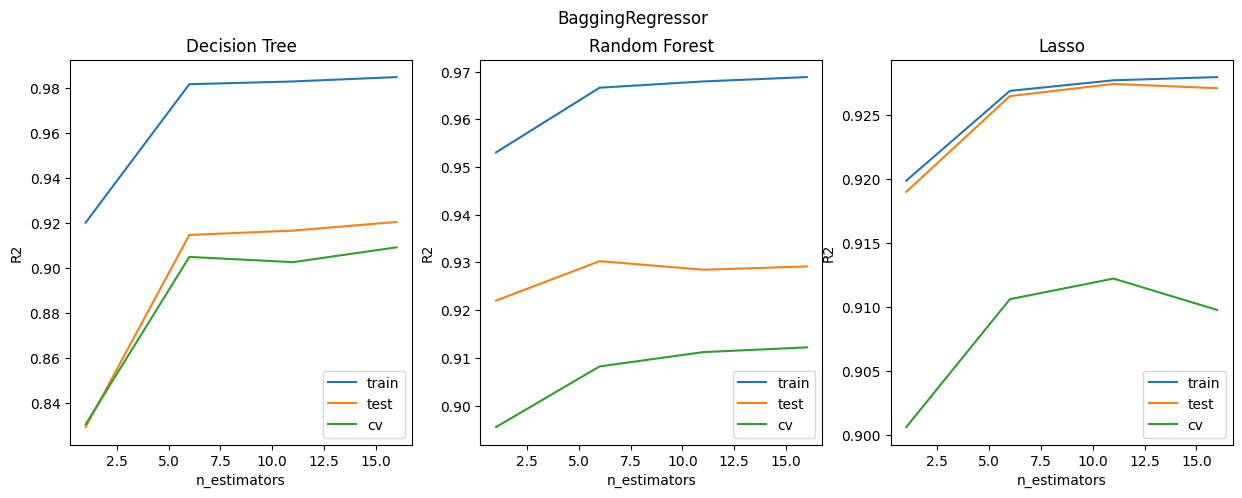

In [85]:
base_ests = {
    'Decision Tree': DecisionTreeRegressor,
    'Random Forest': RandomForestRegressor,
    'Lasso': Lasso
}
bag_reg_res = plot_metric(BaggingRegressor, base_ests, range(1, 20, 5), x_train, y_train, x_test, y_test)

## Бустинг

## Графики зависимости

Progress: 1/30 models evaluated
Progress: 2/30 models evaluated
Progress: 3/30 models evaluated
Progress: 4/30 models evaluated
Progress: 5/30 models evaluated
Progress: 6/30 models evaluated
Progress: 7/30 models evaluated
Progress: 8/30 models evaluated
Progress: 9/30 models evaluated
Progress: 10/30 models evaluated
Progress: 11/30 models evaluated
Progress: 12/30 models evaluated
Best model: Linear Regression
Best hyperparameter: 0.01
Best score: 0.9283195723295996


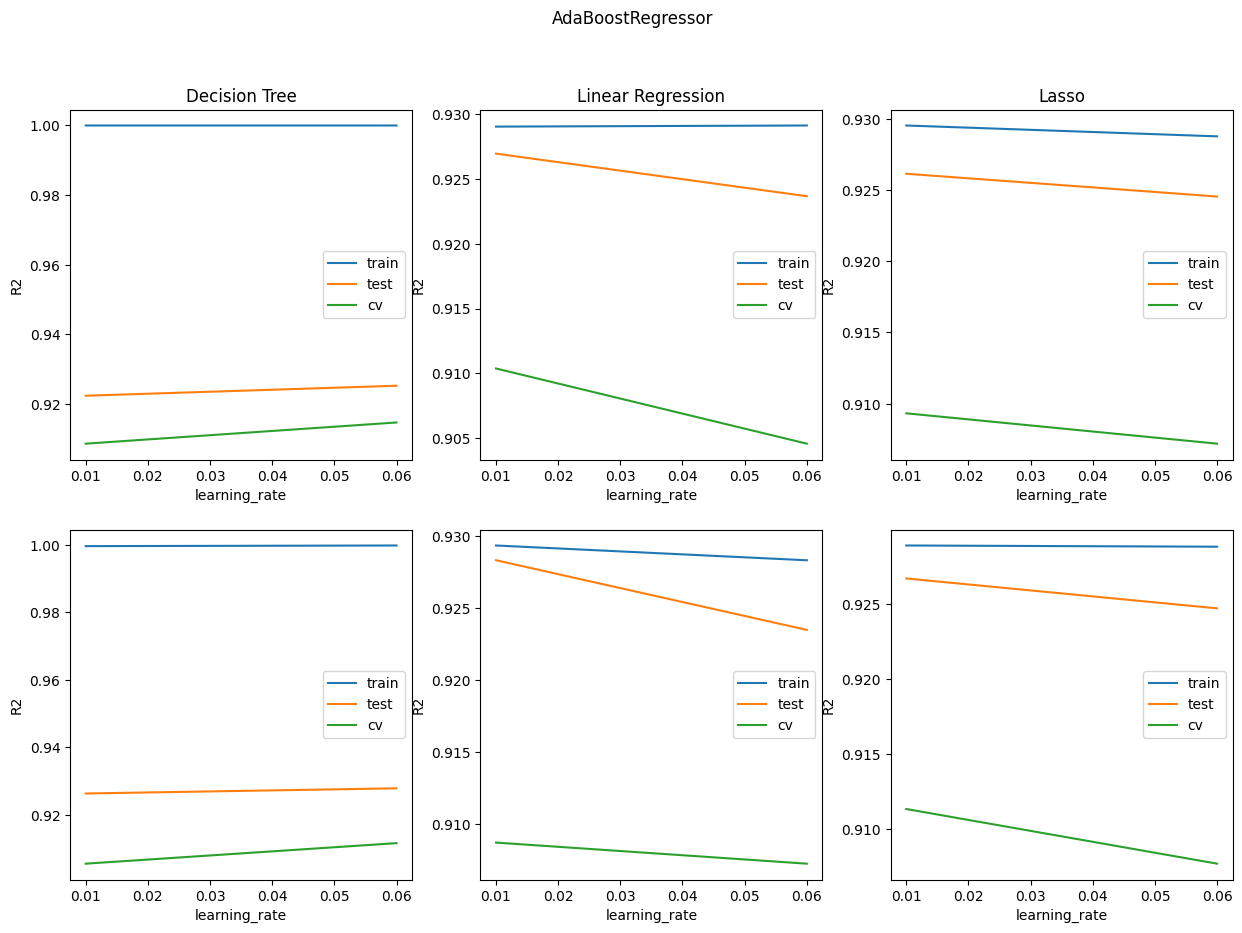

In [86]:
base_ests = {
    'Decision Tree': DecisionTreeRegressor,
    'Linear Regression': LinearRegression,
    'Lasso': Lasso
}

bst_reg_res = plot_metric(AdaBoostRegressor, base_ests, range(1, 50, 5), x_train, y_train, x_test, y_test,
            learning_rate=tuple(x / 100 for x in range(1, 10, 5)))

## Стекинг

Best score: 0.9324422291787637


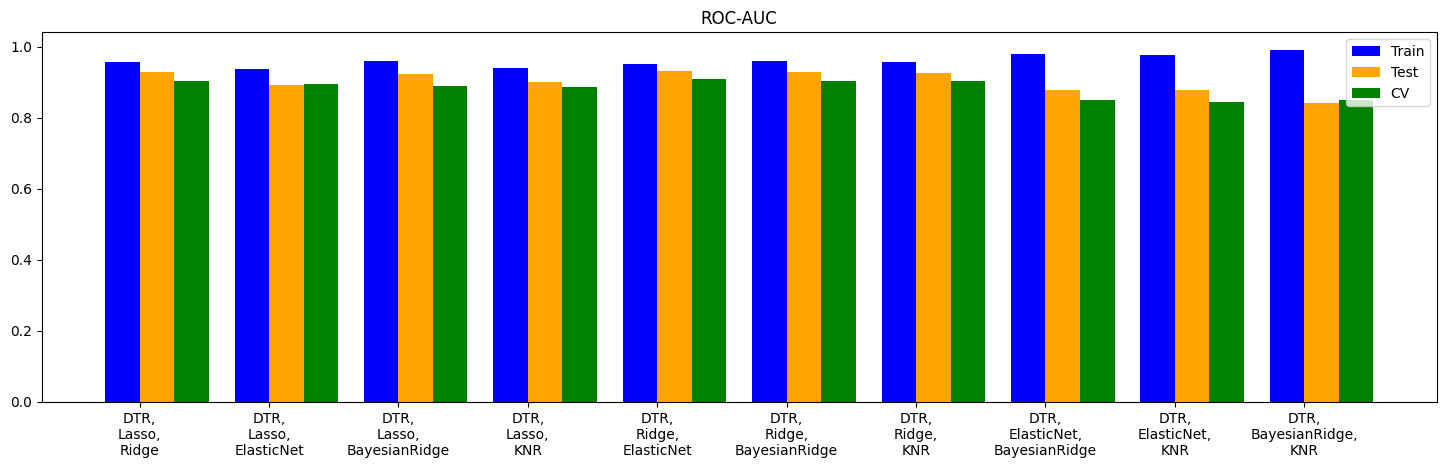

In [87]:
estimators = (
    ("dtr", DecisionTreeRegressor()),
    ("lasso", Lasso(tol=0.1)),
    ("ridge", Ridge()),
    ("elnet", ElasticNet()),
    ("bridge", BayesianRidge()),
    ("knr", KNeighborsRegressor())
)

# Создание кортежа всех возможных комбинаций оценщиков
comb = tuple()
for value in range(1, len(estimators) + 1):
    for combination in combinations(estimators, value):
        comb += (list(combination),)

stack_reg_res = metric_comb_comp(StackingRegressor, comb, (3, 3), "roc_auc", 10, x_train, y_train, x_test, y_test)

## Сравнение ансамблей

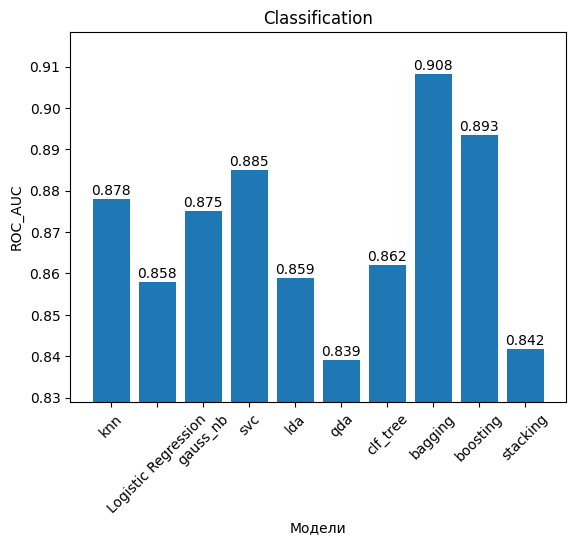

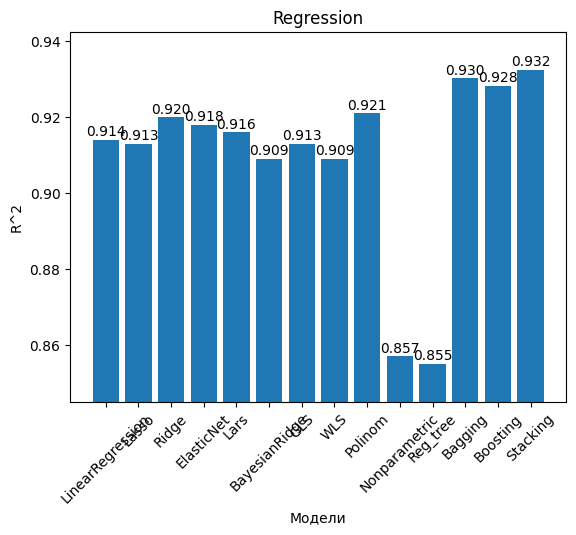

In [103]:
import matplotlib.pyplot as plt

clfs_names_1 = ['knn', 'Logistic Regression', 'gauss_nb', 'svc', 'lda', 'qda', 'clf_tree', 'bagging', 'boosting', 'stacking']
scores_1 = [0.878, 0.858, 0.875, 0.885, 0.859, 0.839, 0.862, bag_clas_res, bst_clas_res, stack_clas_res]
plot_scores(clfs_names_1, scores_1, 'Classification', 'ROC_AUC')

clfs_names_2 = ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'Lars', 'BayesianRidge', 'GLS', 'WLS', 'Polinom', 'Nonparametric', 'Reg_tree', 'Bagging', 'Boosting', 'Stacking']
scores_2 = [0.914, 0.913, 0.920, 0.918, 0.916, 0.909, 0.913, 0.909, 0.921, 0.857, 0.855, bag_reg_res, bst_reg_res, stack_reg_res]
plot_scores(clfs_names_2, scores_2, 'Regression', 'R^2')
